<h1 style="text-align:center;">Capstone Project - The Battle of Neighborhoods (Week 1)</h1>

# Table of Contents
* [Introduction](#introduction)
* [Methodology](#methodology)
    * [Some lib to install](#2.4.2.1.2)
    * [Package to import](#packageToImport)
    * [Download data from kaggle](#downloadDataFromKaggle)
    * [Data Expore](#dataExplore)
    * [Data Clean](#dataClean)
    * [Prepare RFM data](#prepareRFMData)
        * [1D data segmentation](#1dDataSegmentation)
            * [Jenks natural breaks](#jenksNaturalBreaks)
            * [Split By Percentile](#splitByPercentile)
        * [Create RFM tag](#createRFMTag)
        * [RFM segmentation](#RFMSegmentation)
    * [Classify customer level with RFM](#classifyCustomerLevelWithRFM)
* [Result](#result)
* [Conclusion](#conclusion)
* [Reference](#reference)
* [Appendices](#appendices)
---

# 1 Introduction<a class="anchor" id="1"></a>

## 1.1 Background<a class="anchor" id="1.1"></a>
I may have a convenience store after several years, then I will have many customers. I can use RFM(Recency, Frequency, Monetary Value) analysis to find out the customer structure.

RFM(Recency, frequency, monetary value) is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:
* Recency: How recently a customer has made a purchase.
* Frequency: How often a customer makes a purchase.
* Monetary Value: How much money a customer spends on purchases.

After I have a RFM data, I will split the numbers into segments, then I can use K-means to find out how many customer classes I have, and what to do with them.

## 1.2 Problem<a class="anchor" id="1.2"></a>
* What is the structure of them? 
* Does my store still running well? 
* What should I do if it not well? 

## 1.3 Interest<a class="anchor" id="1.3"></a>
May be there is someone else, like me, confused by the sale status. Also can use RFM and K-means to find out what happened to your store.

## 1.4 Environment to prepare<a class="anchor" id="1.4"></a>

**Some lib to install**

In [1]:
# uncomment them if you dong't have the lib.
# !pip install opendatasets
# !pip install jenkspy
# !pip3 install gapkmean
# !pip install pyecharts -U

**Package to import**

In [2]:
import opendatasets as od
import pandas as pd
# show more rows
pd.set_option('max_row',100)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import math
import jenkspy
from jenkspy import jenks_breaks
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# pyecharts
from pyecharts import options as opts
from pyecharts.charts import Parallel
from pyecharts.charts import Pie
from pyecharts.charts import HeatMap
from pyecharts.charts import Scatter3D

# 2 Data<a class="anchor" id="2"></a>

## 2.1 Data source<a class="anchor" id="2.1"></a>
I found some data about sale from kaggle. You can dowload the [data from kaggle](https://www.kaggle.com/carrie1/ecommerce-data/download). I have "InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country" in it.

### 2.1.1 Download data from kaggle<a class="anchor" id="2.1.1"></a>

**Download the data from kaggle, you need username and password.**

In [3]:
od.download("https://www.kaggle.com/carrie1/ecommerce-data/download")

Skipping, found downloaded files in ".\ecommerce-data" (use force=True to force download)


### 2.1.2 Read csv file into pandas dataframe<a class="anchor" id="2.1.2"></a>

In [4]:
# read sale data from csv
df = pd.read_csv("./ecommerce-data/data.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 2.2 Data explore<a class="anchor" id="2.2"></a>

**Show data info, we can find column name and data type**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Show data shape, how many rows and columns in the dataframe**

In [6]:
df.shape

(541909, 8)

**Describe data**

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


**Find if there is something missing, we can see "CustomerID" and "Description" have missing data**

In [8]:
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

## 2.3 Data clean<a class="anchor" id="2.3"></a>

**We don't need "Description"**

In [9]:
dfNotNull = df.drop("Description", axis = 1, inplace = False)
dfNotNull.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**If CustomerID is null, then it should be delete from the dataframe**

In [10]:
dfNotNull.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
dfNotNull.isnull().sum().sort_values(ascending=False)

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

**Correct column datatype**

In [11]:
dfNotNull = dfNotNull.astype({
    'InvoiceNo': 'object',
    'StockCode': 'object',
    'Quantity': 'int64',
    'InvoiceDate': 'object',
    'UnitPrice': 'float64',
    'CustomerID': 'int64',
    'Country': 'object'
})
dfNotNull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Quantity     406829 non-null  int64  
 3   InvoiceDate  406829 non-null  object 
 4   UnitPrice    406829 non-null  float64
 5   CustomerID   406829 non-null  int64  
 6   Country      406829 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 24.8+ MB


**Drop duplicated data**

In [12]:
print('Brfor drop duplicated data: ',dfNotNull.duplicated().sum())
dfNotNull.drop_duplicates(inplace=True)
print('After drop duplicated data: ',dfNotNull.duplicated().sum())

Brfor drop duplicated data:  5227
After drop duplicated data:  0


**Fix Quantity**
There should not be less then 1.

In [13]:
print('Before fix Quantity: ',dfNotNull.shape)
dfNotNull = dfNotNull.loc[lambda dfNotNull: dfNotNull['Quantity'] >= 1]
print('After fix Quantity: ',dfNotNull.shape)

Before fix Quantity:  (401602, 7)
After fix Quantity:  (392730, 7)


**Fix UnitPrice**
There should not be negative number.

In [14]:
print('before fix UnitPrice error: ',dfNotNull.shape)
dfNotNull = dfNotNull.loc[lambda dfNotNull: dfNotNull['UnitPrice'] > 0]
print('before fix UnitPrice error: ',dfNotNull.shape)

before fix UnitPrice error:  (392730, 7)
before fix UnitPrice error:  (392690, 7)


**Formate InvoiceDate string to datatime**

In [15]:
dfNotNull[["InvoiceDate"]] = dfNotNull[["InvoiceDate"]].apply(lambda x: pd.to_datetime(x["InvoiceDate"]), axis = 1)
dfNotNull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392690 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392690 non-null  object        
 1   StockCode    392690 non-null  object        
 2   Quantity     392690 non-null  int64         
 3   InvoiceDate  392690 non-null  datetime64[ns]
 4   UnitPrice    392690 non-null  float64       
 5   CustomerID   392690 non-null  int64         
 6   Country      392690 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 24.0+ MB


## 2.4 Data processing<a class="anchor" id="2.4"></a>

### 2.4.1 Prepare RFM data<a class="anchor" id="2.4.1"></a>

#### 2.4.1.1 Recency: How recently a customer has made a purchase<a class="anchor" id="2.4.1.1"></a>

In [16]:
print("min time: ",dfNotNull['InvoiceDate'].min(), ", max time:",dfNotNull['InvoiceDate'].max())
collectTime = pd.to_datetime("2011-12-10") 
dfNotNull['R'] = (collectTime - dfNotNull['InvoiceDate']).dt.days
R = dfNotNull.groupby(by=['CustomerID'])['R']
R = R.agg([('R','min')])
R.head()

min time:  2010-12-01 08:26:00 , max time: 2011-12-09 12:50:00


,R
CustomerID,
12346,325
12347,2
12348,75
12349,18
12350,310


#### 2.4.1.2 Frequency: How often a customer makes a purchase<a class="anchor" id="2.4.1.2"></a>

In [17]:
F = dfNotNull.groupby(by=['CustomerID'])['CustomerID'].agg([('F','count')])
F.head()

,F
CustomerID,
12346,1
12347,182
12348,31
12349,73
12350,17


#### 2.4.1.3 Monetary Value: How much money a customer spends on purchases<a class="anchor" id="2.4.1.3"></a>

**Add a TotalAmount as Quantity\*UnitPrice**

In [18]:
dfNotNull["TotalAmount"]=dfNotNull[["Quantity","UnitPrice"]].apply(lambda x: x["Quantity"] * x["UnitPrice"], axis = 1)
dfNotNull.describe()

,Quantity,UnitPrice,CustomerID,R,TotalAmount
count,392690.000000,392690.000000,392690.000000,392690.000000,392690.000000
mean,13.118997,3.125913,15287.855925,151.750579,22.630210
std,180.492710,22.241892,1713.535580,112.671861,311.098933
min,1.000000,0.001000,12346.000000,0.000000,0.001000
25%,2.000000,1.250000,13955.000000,50.000000,4.950000
50%,6.000000,1.950000,15150.000000,131.000000,12.450000
75%,12.000000,3.750000,16791.000000,246.000000,19.800000
max,80995.000000,8142.750000,18287.000000,373.000000,168469.600000


In [19]:
M = dfNotNull.groupby(by=['CustomerID'])['TotalAmount'].agg([('M',sum)])
M.head()

,M
CustomerID,
12346,77183.60
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40


#### 2.4.1.4 Create RFM data<a class="anchor" id="2.4.1.4"></a>

In [20]:
RFM = R.join(F).join(M)
RFM.describe()

,R,F,M
count,4338.000000,4338.000000,4338.000000
mean,92.059474,90.523283,2048.560868
std,100.012264,225.506977,8984.682547
min,0.000000,1.000000,3.750000
25%,17.000000,17.000000,306.482500
50%,50.000000,41.000000,668.570000
75%,141.750000,98.000000,1660.597500
max,373.000000,7676.000000,280206.020000


# 3 Methodology<a class="anchor" id="methodology"></a>

## 3.1 Data segmentation<a class="anchor" id="3.1"></a>

#### 3.1.1 1D Data Segmentation<a class="anchor" id="3.1.1"></a>
**We use percentile or jenks natural breaks to split the data, then chose a better group**

##### 3.1.1.1 Function to visualize the taged RFM data<a class="anchor" id="3.1.1.1"></a>

In [21]:
# visualize taged rfm dataframe
def showTagedRFM(df):
    fig, ax = plt.subplots(1,3,figsize=(15, 2.5))
    ax[0].scatter(df["R"], df["rTag"], alpha=0.3, edgecolors='none', color="tab:blue")
    ax[0].set_xlabel("R", fontsize=15)
    ax[0].set_ylabel("Tag", fontsize=15)
    ax[0].set_title('R Tag')

    ax[1].scatter(df["F"], df["fTag"], alpha=0.3, edgecolors='none', color="tab:green")
    ax[1].set_xlabel("F", fontsize=15)
    ax[1].set_ylabel("Tag", fontsize=15)
    ax[1].set_title('F Tag')

    ax[2].scatter(df["M"], df["mTag"], alpha=0.3, edgecolors='none', color="tab:orange")
    ax[2].set_xlabel("M", fontsize=15)
    ax[2].set_ylabel("Tag", fontsize=15)
    ax[2].set_title('M Tag')

    plt.show()

##### 3.1.1.2 Split by Jenks Natural Breaks functions<a class="anchor" id="3.1.1.2"></a>

In [22]:
# split by Jenks Natural Breaks
# evaluate function
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenks_breaks(array, classes)

    # do the actual classification
    classified = np.array([classifyByJenksNaturalBreak(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

# used in goodness_of_variance_fit
def classifyByJenksNaturalBreak(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

# classify and visualization
## d is dataset, gapStop is min gav gap value(gav - gavHis) to stop
def findJenksBreaks(d, gapStop, chartFlag = True): 
    classArray = []
    gvfArray = []
    classNum = 1
    gvf = 0.0
    gvfHis = 0.0    
    while True:
        classNum = classNum + 1
        gvf = goodness_of_variance_fit(d, classNum)    
        gap = gvf - gvfHis
        gvfHis = gvf        
        if gap >= gapStop:
            if chartFlag != False:
                classArray.append(classNum)
                gvfArray.append(gvf)
        else:
            break
    if chartFlag != False:
        gvfDf = pd.DataFrame({"classes": classArray,"gvfs": gvfArray})
        plt.plot(classArray, gvfArray)
        plt.show()
    return classNum

# get data segment, return split points
def getSegmentByJenks(d, gapStop, chartFlag = True): 
    breaks = jenkspy.jenks_breaks(d, nb_class = findJenksBreaks(d, gapStop, chartFlag))
    return breaks[1:(len(breaks)-1)]

# get rfm segments
def getRfmSegmentByJenks(d,chartFlag = True): 
    rfmGap = {
            "R":getSegmentByJenks(d["R"].to_numpy(), 0.015, chartFlag),
            "F":getSegmentByJenks(d["F"].to_numpy(), 0.015, chartFlag),
            "M":getSegmentByJenks(d["M"].to_numpy(), 0.015, chartFlag)
        }
    return rfmGap

##### 3.1.1.3 Split By Percentile functions<a class="anchor" id="3.1.1.3"></a> 

In [23]:
# split by percentile
def getSegmentByPercentile(d):
    return [np.percentile(d, 20),np.percentile(d, 40),np.percentile(d, 60),np.percentile(d, 80)]
def getRfmSegmentByPercentile(d):
    return {"R":getSegmentByPercentile(RFM["R"]),"F":getSegmentByPercentile(RFM["F"]),"M":getSegmentByPercentile(RFM["M"])}

##### 3.1.1.4 Label RFM functions<a class="anchor" id="3.1.1.4"></a> 

In [24]:
# get value tag by gap
def getTagByGap(val,p):    
    ret = 1
    maxlen = len(p)
    if val <= p[0]:
        return ret
    if val > p[maxlen-1]:
        return (maxlen +1)
    for i in range(1,maxlen):
        if val > p[i-1] and val <= p[i]:
            return (i + 1)
def parseTags(row):
    ret = [getTagByGap(row["R"],rfmGap["R"]),getTagByGap(row["F"],rfmGap["F"]),getTagByGap(row["M"],rfmGap["M"])]
    return ret
def rfmTag(rfmSet,rfmDescribe):
    tmp = rfmSet.apply(lambda x: parseTags(x),axis = 1,result_type = "expand")
    return tmp

##### 3.1.1.5 Labeled by jenks natural breaks<a class="anchor" id="3.1.1.5"></a> 

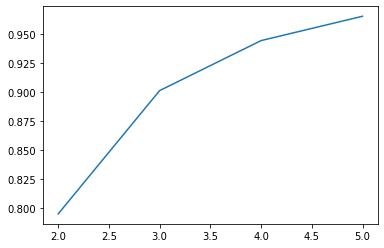

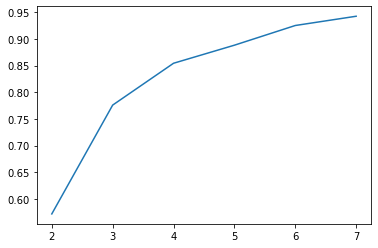

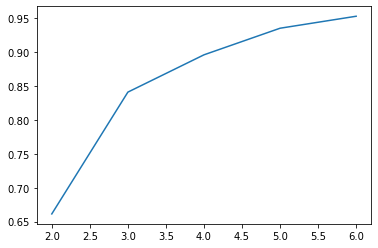

{'R': [38.0, 89.0, 152.0, 222.0, 299.0],
 'F': [68.0, 182.0, 378.0, 740.0, 1477.0, 2677.0, 5670.0],
 'M': [2392.830000000001,
  8347.199999999992,
  21429.39,
  44534.3,
  91062.37999999996,
  194390.79000000007]}

In [25]:
rfmGap = getRfmSegmentByJenks(RFM)
rfmGap

**Show rfm tag data distribution**

In [26]:
tagedRFM = RFM.join(rfmTag(RFM,rfmGap), how = "left")
tagedRFM.rename(columns={0: "rTag", 1: "fTag", 2: "mTag"}, inplace=True)
tagedRFM.head()

,R,F,M,rTag,fTag,mTag
CustomerID,,,,,,
12346,325,1,77183.60,6,1,5
12347,2,182,4310.00,1,2,2
12348,75,31,1797.24,2,1,1
12349,18,73,1757.55,1,2,1
12350,310,17,334.40,6,1,1


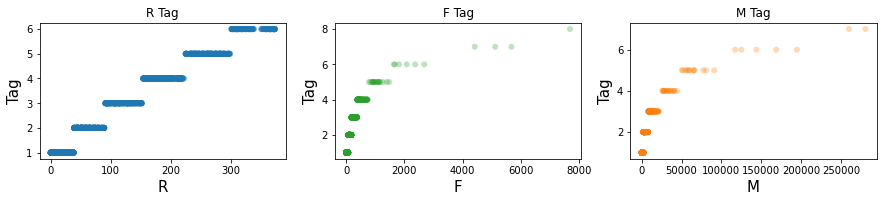

In [27]:
showTagedRFM(tagedRFM)

##### 3.1.1.6 Labeled by percentile<a class="anchor" id="3.1.1.6"></a> 

In [28]:
rfmGap = getRfmSegmentByPercentile(RFM)

**Show rfm tag data distribution**

In [29]:
tagedRFM = RFM.join(rfmTag(RFM,rfmGap), how = "left")
tagedRFM.rename(columns={0: "rTag", 1: "fTag", 2: "mTag"}, inplace=True)
tagedRFM.head()

,R,F,M,rTag,fTag,mTag
CustomerID,,,,,,
12346,325,1,77183.60,5,1,5
12347,2,182,4310.00,1,5,5
12348,75,31,1797.24,4,3,4
12349,18,73,1757.55,2,4,4
12350,310,17,334.40,5,2,2


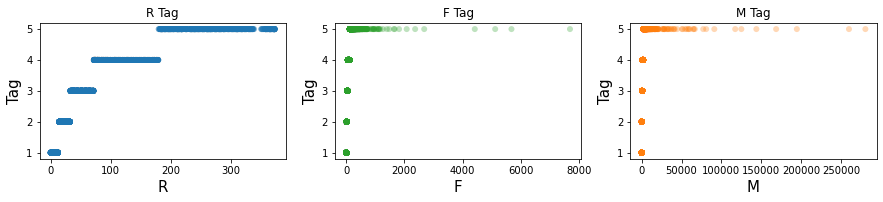

In [30]:
showTagedRFM(tagedRFM)

**Compare "Jenks Natural Breaks" and "Split By Percentile", it showed "R" split by percentile is ok, but "F" and "M" is not fit.
We should use "Jenks Natural Breaks" for the segmentation.**

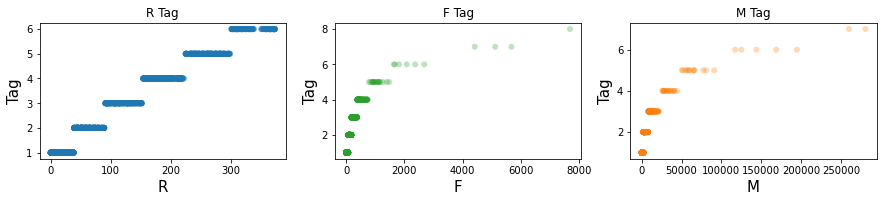

In [31]:
# Use Jenks Natural Breaks for segmentation
rfmGap = getRfmSegmentByJenks(RFM,False)
tagedRFM = RFM.join(rfmTag(RFM,rfmGap), how = "left")
tagedRFM.rename(columns={0: "rTag", 1: "fTag", 2: "mTag"}, inplace=True)
showTagedRFM(tagedRFM)

##### 3.1.1.7 RFM segmentation<a class="anchor" id="3.1.1.7"></a>
|type|1|2|3|4|5|6|7|8|
|---|---|---|---|---|---|---|---|---|
|R|[min,3528.0]|(3528.0,3579.0]|(3579.0,3642.0]|(3642.0,3712.0]|(3712.0,3789.0]|(3789.0,max]|
|F|[min,68.0]|(68.0,182.0]|(182.0,378.0]|(378.0,740.0]|(740.0,1477.0]|(1477.0,2677.0]|(2677.0,5670.0]|(5670.0,max]|
|M|[min,2392.83]|(2392.83,8347.20]|(8347.20,21429.39]|(21429.39,44534.3]|(44534.3,91062.38]|(91062.38,194390.79]|(194390.79,max]|

## 3.2 Classify customer level with RFM<a class="anchor" id="3.2"></a>

### 3.2.1 Create taged RFM data<a class="anchor" id="3.2.1"></a>
**We will classify customer level, use taged rfm data**

In [32]:
customerRFMData =tagedRFM.loc[:, ["rTag","fTag","mTag"]]
customerRFMData.head()

,rTag,fTag,mTag
CustomerID,,,
12346,6,1,5
12347,1,2,2
12348,2,1,1
12349,1,2,1
12350,6,1,1


**Copy the data for next step**

In [33]:
stdRFM = customerRFMData.copy()

In [34]:
stdRFM.describe()

,rTag,fTag,mTag
count,4338.000000,4338.000000,4338.000000
mean,2.337022,1.511296,1.213923
std,1.589050,0.832522,0.554496
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,1.000000,1.000000
75%,3.000000,2.000000,1.000000
max,6.000000,8.000000,7.000000


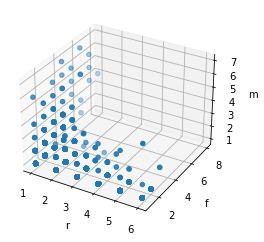

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(stdRFM["rTag"], stdRFM["fTag"], stdRFM["mTag"])
ax.set_xlabel('r')
ax.set_ylabel('f')
ax.set_zlabel('m')

plt.show()

### 3.2.2 Function for K-means<a class="anchor" id="3.2.2"></a>

In [36]:
# Kmeans
def classifyByKmeans(dataframe, classNum):
    km = KMeans(n_clusters = classNum)
    km.fit(dataframe)
    km.predict(dataframe)   
    return {"class": classNum, "score": silhouette_score(dataframe,km.labels_),"sse": km.inertia_, "model":km}
# Find best K
def findBestK(dataframe, kMax):
    result = []      
    for i in range(2,kMax): 
        result.append(classifyByKmeans(dataframe,i))        
    fig = plt.figure(figsize = [16,8])
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    resultSet = pd.DataFrame(result)
    ax1.plot(resultSet["class"], resultSet["score"], ms=2) 
    ax1.set_title("score")
    ax1.xaxis.set_major_locator(MultipleLocator(1))
    
    ax2.plot(resultSet["class"], resultSet["sse"], ms=2)
    ax2.set_title("sse")
    ax2.xaxis.set_major_locator(MultipleLocator(1))
    
    ax1.grid()
    ax2.grid()

    plt.show()
    return resultSet

# visiualization classified rfm data 
def drawKmeansResult(df,title, kMax):
    range_color = [
        '#FFA500','#BFEFFF', '#8B7B8B', '#FFE1FF', '#551A8B', '#9B30FF',
        '#8B008B', '#FF00FF', '#CD6889', '#FF82AB', '#8B0000', '#FF0000'
    ]
    chart = Scatter3D(
            init_opts=opts.InitOpts(width="1000px", height="600px")
        ).add(
            series_name="",
            data = df.loc[:,["rTag","fTag","mTag","label"]].values.tolist(),
            xaxis3d_opts=opts.Axis3DOpts(
                name="R",
                type_="value",                
            ),
            yaxis3d_opts=opts.Axis3DOpts(
                name="F",
                type_="value",                
            ),
            zaxis3d_opts=opts.Axis3DOpts(
                name="M",
                type_="value",                
            ),
            grid3d_opts=opts.Grid3DOpts(width=100, height=100, depth=100, rotate_speed=20, is_rotate=False),
        ).set_global_opts(
            title_opts=opts.TitleOpts(title=title),
            visualmap_opts=[
                opts.VisualMapOpts(
                    type_="color",
                    is_calculable=True,   
                    dimension=[3],
                    range_text=["ClassMax","ClassMin"],
                    max_= kMax,
                    min_ = 0,
                    split_number = kMax,
                    is_piecewise = True,
                    pos_top="100px",
                    range_color=range_color,
                ),         
            ],
            tooltip_opts = [
                opts.TooltipOpts(
                    formatter = "r,f,m,class:{c}"
                )
            ]
        )
    return chart

### 3.2.3 Find best K<a class="anchor" id="3.2.3"></a>
**We can see, k is 10**

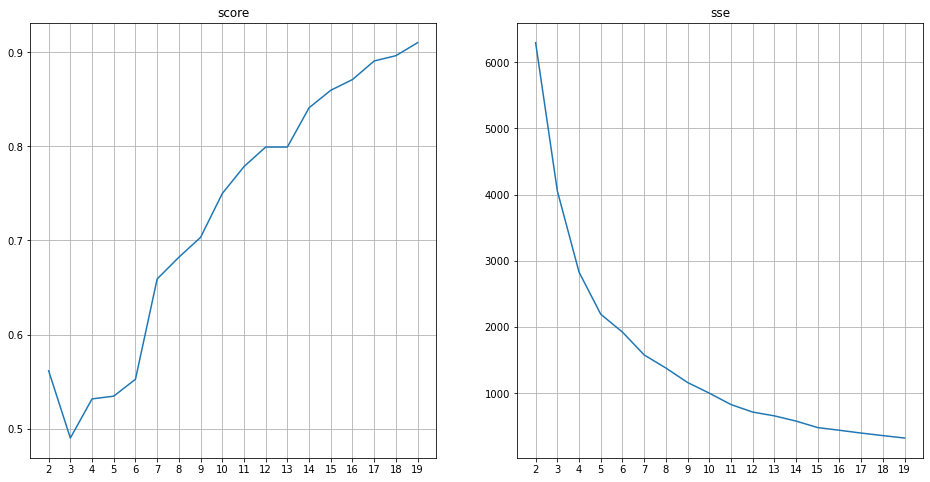

In [37]:
resultSet = findBestK(stdRFM,20)

### 3.2.4 Create the K-means model<a class="anchor" id="3.2.4"></a>
**Take 8th model as k started from 2**

In [38]:
km = resultSet.loc[8,:]["model"]
print(resultSet.loc[8,:],km.cluster_centers_,km.labels_)

class                       10
score                 0.749867
sse                1002.771267
model    KMeans(n_clusters=10)
Name: 8, dtype: object [[1.         1.         1.03886926]
 [5.42811502 1.05591054 1.02396166]
 [1.08108108 3.26044226 1.82555283]
 [2.         1.         1.02155172]
 [4.         1.13283208 1.03258145]
 [2.28070175 2.10818713 1.25146199]
 [1.         2.         1.        ]
 [1.         4.24242424 3.86363636]
 [3.         1.         1.01818182]
 [1.01980198 1.97029703 2.16336634]] [1 9 3 ... 0 2 5]


#### Count by tag and label

In [39]:
stdRFM["label"] = km.labels_ + 1
# count by tag and label
groupByResult = stdRFM.groupby(by=["rTag","fTag","mTag","label"])["label"].count().reset_index(name="count")
groupByResult.head()

,rTag,fTag,mTag,label,count
0,1,1,1,1,816
1,1,1,2,1,33
2,1,1,3,10,3
3,1,1,4,10,2
4,1,1,6,8,1


In [40]:
# show the cahrt
chart = drawKmeansResult(groupByResult,"RFM classes",10)
chart.render_notebook()

#### RFM tag, label, count visualization

In [41]:
# a parallel chart
parallel_axis=[
    {"dim":0,"name":"R"},
    {"dim":1,"name":"F"},
    {"dim":2,"name":"M"},
    {"dim":3,"name":"Class"},
    {"dim":4,"name":"Count"}
]

data = groupByResult[["rTag","fTag","mTag","label","count"]].values.tolist()

p=(
    Parallel(init_opts=opts.InitOpts(width="800px",height="600px"))
    .add_schema(schema=parallel_axis)    
    .add(
        series_name="RFM",
        data=data,
        linestyle_opts=opts.LineStyleOpts(width=4,opacity=1)
    ).set_global_opts(
        visualmap_opts=[
            opts.VisualMapOpts(
                type_="color",
                max_ = 10,
                is_calculable=True,                
                pos_top="10"
            )            
        ]
    )
)
p.render_notebook()


In [42]:
# a pie chart
rfmPie = stdRFM.groupby(by=["label"])["label"].count().reset_index(name="count")
rfmPie.head()
rfmPieList = rfmPie.values.tolist()

c = (
    Pie()
    .add(
        "",
        [list(z) for z in rfmPieList],
        radius=["30%", "75%"],
        center=["50%", "50%"],
        rosetype="area",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="RFM Class Pie"),
        legend_opts=opts.LegendOpts(pos_left="15%"),
    )
    .set_series_opts(label_opts=opts.LabelOpts(formatter="class-{b}: {c}"))    
)
c.render_notebook()

---

# Result and Discussion<a class="anchor" id="result"></a>

We have do the [RFM segmentation](#3.1.1.7), and have the table below.

|type|1|2|3|4|5|6|7|8|
|---|---|---|---|---|---|---|---|---|
|R|[min,3528.0]|(3528.0,3579.0]|(3579.0,3642.0]|(3642.0,3712.0]|(3712.0,3789.0]|(3789.0,max]|
|F|[min,68.0]|(68.0,182.0]|(182.0,378.0]|(378.0,740.0]|(740.0,1477.0]|(1477.0,2677.0]|(2677.0,5670.0]|(5670.0,max]|
|M|[min,2392.83]|(2392.83,8347.20]|(8347.20,21429.39]|(21429.39,44534.3]|(44534.3,91062.38]|(91062.38,194390.79]|(194390.79,max]|

<div style="text-align:center;">RFM segments</div>

We created K-means model. K is **10**, score is 0.749867, sse is 1002.771267.

Cluster centers is below:

|   R    |   F    |   M    |
|--------|--------|--------|
|1.000000|1.000000|1.038869|
|5.428115|1.055911|1.023962|
|1.081081|3.260442|1.825553|
|2.000000|1.000000|1.021552|
|4.000000|1.132832|1.032581|
|2.280702|2.108187|1.251462|
|1.000000|2.000000|1.000000|
|1.000000|4.242424|3.863636|
|3.000000|1.000000|1.018182|
|1.019802|1.970297|2.163366|

<div style="text-align:center;">classify cluster center</div>

We can see rfm data and which class they belong, collect the classes as 6 level "new, normal, good, attention, risk, lost". 
Fnally we have 6 class 10 subclass and 73 detail class.


In [84]:
# the class and subclass mapping 
lvlSet = [{"new":[1,6],"normal":[3,7],"good":[9,10], "attention": [4], "risk":[5],"lost":[2,8]}]
lvlMap =[
    [1,"new"],[2,"lost"],[3,"normal"],[4,"attention"],[5,"risk"],[6,"new"],
    [7,"normal"],[8,"lost"],[9,"good"],[10,"good"]
]
lvlDf = pd.DataFrame(lvlMap,columns=["label","lvl"])

|subclass|class|
|--------|-----|
|1	|new|
|2	|lost|
|3	|normal|
|4	|attention|
|5	|risk|
|6	|new|
|7	|normal|
|8	|lost|
|9	|good|
|10	|good|

<div style="text-align:center;">class subclass mapping</div>

In [85]:
# get a result dataset copy
resultTable = groupByResult.copy()
# sort by label and rfm
resultTable = resultTable.sort_values(["label","rTag","fTag","mTag","count"]).reset_index(drop=True)
resultTable = resultTable.join(lvlDf.set_index('label'), on="label", rsuffix='',how = "left")
resultTable["lvl2"]=resultTable[["label", "rTag", "fTag", "mTag"]].apply(lambda x: "class" + str(x["label"]) + "-" + str(x["rTag"]) + str(x["fTag"]) + str(x["mTag"]), axis = 1)

|SeqNO|R Tag|F Tag|M Tag|Subclass|Count|
|-----|-----|-----|-----|-----|-----|
|1|1|1|1|1|816|
|2|1|1|2|1|33|
|3|5|1|1|2|338|
|4|5|1|2|2|3|
|5|5|1|4|2|1|
|6|5|2|1|2|14|
|7|5|2|2|2|2|
|8|6|1|1|2|249|
|9|6|1|2|2|1|
|10|6|1|5|2|1|
|11|6|2|1|2|15|
|12|6|3|2|2|2|
|13|1|3|1|3|89|
|14|1|3|2|3|17|
|15|1|3|3|3|27|
|16|1|4|1|3|11|
|17|1|4|2|3|65|
|18|1|5|2|3|12|
|19|2|3|2|3|24|
|10|2|3|3|3|3|
|21|2|4|1|3|1|
|22|2|4|2|3|5|
|23|2|1|1|4|68|
|24|2|1|2|4|15|
|25|4|1|1|5|34|
|26|4|1|2|5|2|
|27|4|1|3|5|1|
|28|4|1|4|5|1|
|29|4|2|1|5|43|
|30|4|2|2|5|6|
|31|4|3|1|5|2|
|32|2|2|1|6|16|
|33|2|2|2|6|63|
|34|2|3|1|6|23|
|35|3|2|1|6|64|
|36|3|2|2|6|16|
|37|3|2|3|6|1|
|38|3|3|1|6|7|
|39|3|3|2|6|3|
|40|3|4|1|6|1|
|41|4|3|2|6|2|
|42|1|2|1|7|42|
|43|1|1|6|8|1|
|44|1|2|5|8|2|
|45|1|3|4|8|6|
|46|1|3|5|8|2|
|47|1|3|6|8|1|
|48|1|4|3|8|30|
|49|1|4|4|8|2|
|50|1|4|5|8|3|
|51|1|4|6|8|1|
|52|1|4|7|8|1|
|53|1|5|3|8|4|
|54|1|5|4|8|1|
|55|1|5|5|8|1|
|56|1|5|6|8|1|
|57|1|6|2|8|1|
|58|1|6|3|8|1|
|59|1|6|5|8|3|
|60|1|6|7|8|1|
|61|1|7|4|8|1|
|62|1|7|5|8|1|
|63|1|7|6|8|1|
|64|1|8|4|8|1|
|65|3|1|1|9|32|
|66|3|1|2|9|6|
|67|1|1|3|10|3|
|68|1|1|4|10|2|
|69|1|2|2|10|1|
|70|1|2|3|10|1|
|71|1|2|4|10|3|
|72|2|1|3|10|1|
|73|2|2|3|10|3|

<div style="text-align:center;">subclass detailclass mapping</div>

Let 's join the two table.

In [86]:
lvlDf.set_index('label')
resultTable = resultTable.join(lvlDf, on="label", rsuffix='r_',how = "left")
resultTable["lvl2"]=resultTable[["label", "rTag", "fTag", "mTag"]].apply(lambda x: "class" + str(x["label"]) + "-" + str(x["rTag"]) + str(x["fTag"]) + str(x["mTag"]), axis = 1)

Extract class table and sort by class, subclass, detail class

In [87]:
ds = resultTable.loc[:,["lvl","label","lvl2","count"]]
ds = ds.sort_values(["lvl","label","lvl2"]).reset_index(drop=True)

|SeqNO|Class|Subclass|Detail Class|Count|
|-----|-----|--------|------------|-----|
|1|attention|4|class4-211|681|
|2|attention|4|class4-212|15|
|3|good|9|class9-311|324|
|4|good|9|class9-312|6|
|5|good|10|class10-113|3|
|6|good|10|class10-114|2|
|7|good|10|class10-122|174|
|8|good|10|class10-123|16|
|9|good|10|class10-124|3|
|10|good|10|class10-213|1|
|11|good|10|class10-223|3|
|12|lost|2|class2-511|338|
|13|lost|2|class2-512|3|
|14|lost|2|class2-514|1|
|15|lost|2|class2-521|14|
|16|lost|2|class2-522|2|
|17|lost|2|class2-611|249|
|18|lost|2|class2-612|1|
|19|lost|2|class2-615|1|
|20|lost|2|class2-621|15|
|21|lost|2|class2-632|2|
|22|lost|8|class8-116|1|
|23|lost|8|class8-125|2|
|24|lost|8|class8-134|6|
|25|lost|8|class8-135|2|
|26|lost|8|class8-136|1|
|27|lost|8|class8-143|30|
|28|lost|8|class8-144|2|
|29|lost|8|class8-145|3|
|30|lost|8|class8-146|1|
|31|lost|8|class8-147|1|
|32|lost|8|class8-153|4|
|33|lost|8|class8-154|1|
|34|lost|8|class8-155|1|
|35|lost|8|class8-156|1|
|36|lost|8|class8-162|1|
|37|lost|8|class8-163|1|
|38|lost|8|class8-165|3|
|39|lost|8|class8-167|1|
|40|lost|8|class8-174|1|
|41|lost|8|class8-175|1|
|42|lost|8|class8-176|1|
|43|lost|8|class8-184|1|
|44|new|1|class1-111|816|
|45|new|1|class1-112|33|
|46|new|6|class6-221|162|
|47|new|6|class6-222|63|
|48|new|6|class6-231|23|
|49|new|6|class6-321|64|
|50|new|6|class6-322|16|
|51|new|6|class6-323|1|
|52|new|6|class6-331|7|
|53|new|6|class6-332|3|
|54|new|6|class6-341|1|
|55|new|6|class6-432|2|
|56|normal|3|class3-131|89|
|57|normal|3|class3-132|170|
|58|normal|3|class3-133|27|
|59|normal|3|class3-141|11|
|60|normal|3|class3-142|65|
|61|normal|3|class3-152|12|
|62|normal|3|class3-232|24|
|63|normal|3|class3-233|3|
|64|normal|3|class3-241|1|
|65|normal|3|class3-242|5|
|66|normal|7|class7-121|421|
|67|risk|5|class5-411|344|
|68|risk|5|class5-412|2|
|69|risk|5|class5-413|1|
|70|risk|5|class5-414|1|
|71|risk|5|class5-421|43|
|72|risk|5|class5-422|6|
|73|risk|5|class5-431|2|

<div style="text-align:center;">class table</div>

Class table visualization.

In [88]:
from pyecharts.charts import Sunburst

data = []

lvl0 = {}
lvl1 = {}
lvl2 = {}

for item in ds.values.tolist():
    if item[0] in lvl0:
         pass
    else:
        lvl0[item[0]] = {"name": item[0], "children": []}
        
    if item[1] in lvl1:
         pass
    else:
        lvl1[item[1]] = {"name": item[1], "parent": item[0], "children": []}
        
    if item[2] in lvl2:
        pass
    else:
        lvl2[item[2]] = {"name": item[2],"parent": item[1], "value": item[3]}

for k in lvl2:
    lvl1Tmp = lvl1[lvl2[k]["parent"]]
    lvl1Tmp["children"].append(lvl2[k])

lvl2 = {}

for k in lvl1:
    lvl0Tmp = lvl0[lvl1[k]["parent"]]
    lvl0Tmp["children"].append(lvl1[k])    

lvl1 = {}
    
for k in lvl0:    
    data.append(lvl0[k])

lvl0 = {}
    
chart = (
    Sunburst(init_opts=opts.InitOpts(width="1000px", height="600px"))
    .add(
        "",
        data_pair=data,
        highlight_policy="ancestor",
        radius=[0, "95%"],
        sort_="null",
        levels=[
            {},
            {
                "r0": "15%",
                "r": "35%",
                "itemStyle": {"borderWidth": 2},
                "label": {"rotate": "tangential"},
            },
            {
                "r0": "35%", 
                "r": "50%", 
                "label": {"align": "right"}
            },
            {
                "r0": "50%",
                "r": "72%",
                "label": {"position": "outside", "padding": 1, "silent": False},
                "itemStyle": {"borderWidth": 3},
            },
        ],
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="Customer Level"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))    
)
chart.render_notebook()

We have 1545 new, 942 normal, 154 good, 342 attention, 330 risk and 1025 lost, total 4338 customers.

In [89]:
chart = (
    Pie()
    .add(
        "",
        [["New",1545],["Normal",942],["Good",154],["Attention",342],["Risk",330],["Lost",1025]],
        radius=["30%", "75%"],
        center=["50%", "50%"],
        rosetype="area",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="RFM Class Pie"),
        legend_opts=opts.LegendOpts(pos_left="15%"),
    )
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c} [{d}%]"))    
)
chart.render_notebook()

# Conclusion<a class="anchor" id="conclusion"></a>
#### At last we have 6 primary calss and 10 sub class with 73 detail class.
* Lost customers is 23.63%.
* Risk customers is 7.61%.
* Attention customers is 7.88%.
* Normal customers is 21.71%.
* New customers is 33.62%.
* Good customers is 3.55%.

#### So I find out:
* Lack of customer stickiness: total of level risk and attention is more then 15%, need to do preference analysis for them. Some promotion activities should be useful. Level new is 33.62%, member points and gifts may helpful.
* The goods structure is not fit consume preference: level good is much smaller than level normal.
* Level lost is about 1/4, need more promotion activities and advertising to bring them back.
---

# References<a class="anchor" id="reference"></a>

[pyecharts](https://gallery.pyecharts.org/#/README_EN)
[sklearn](https://scikit-learn.org/stable/index.html)
[pandas](https://pandas.pydata.org/)

___

# Appendices<a class="anchor" id="appendices"></a>
You can dowload the [data from kaggle](https://www.kaggle.com/carrie1/ecommerce-data/download)
___ 